### Data Injection

Below is a data pipeline that uses the Yotube API to take available features and meta data to engineer additional features for the modelling of YouTube video likes. In starting this report I looked around me to find a meaningful research question. My partner, Chloe Hayden, is an Australian disability advocate with a large subscribership and not currently using her data to the fullest potential. This pipeline would enable us to look at her success online, create dashboards, and make prediction regarding video success. Unfortunately, it was found that she did not have enough useful instances to train accurate models with, so I have found two creators oeprating in the same space as her to fill in the dataset a little bit. I can only make 10,000 requests of the Youtube API per day which has made this process much slower than I would have liked. Nevertheless, the task was accomplished as follows:  

In [1]:
# Importing necessary modules
    # For Data Selection/cleaning, Feature Engineering, and Data Preproccessing
import pandas as pd
import numpy as np
import datetime as dt
from googleapiclient import discovery
from emoji import UNICODE_EMOJI
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy import stats

    # For any Exploratory Data Analysis and the Heatmap (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
%matplotlib inline

I created an api key at https://console.cloud.google.com/apis/library/youtube.googleapis.com and used YouTube.com urls to obtain channel Ids. I then tested a few channels to see if their data was publically available. I settled on Chloe Hayden's, Paige Layle's, and The aspie world's channels. I obtained data for each seperately and then uploaded and combined the three seperate csv files at the end.

In [2]:
# Enabled api at: https://console.cloud.google.com/apis/library/youtube.googleapis.com
# in credentials panel, create api key: #############################-xMi0

# NOT ENOUGH DATA, PULLING SOME EXTRA FROM SIMILARLY PLACED ADVOCATES TO BULK UP THE DATASET. 
# IN TIME WE WILL NOT NEED OTHER SETS AS CHLOE WILL POST MORE HERSELF IN THE COMING MONTHS.

# Chloe Hayden's channel id = UC2ZkhMUYD37tboIJJgMz-MA     
# The aspie world id = UCOKKRcJey93Ms-dL630UNIQ              # Similar size and audience
# Paige Layle id = UCFd9e6W-saUSwje3-B2lCVg                  # Similar size and audience

# Also tried the following:
# vsauce Id = UC6nSFpj9HTCZ5t-N3Rm3-HA                       # not public
# mrbeast id = UCgoFStVyEsm8tBZP5NC-aBQ                      # not public
# scishow id = UCZYTClx2T1of7BRZ86-8fow                      # not public
# calisthenics movement id = UCZIIRX8rkNjVpP-oLMHpeDw        # this works, but not the right topic or of the right scale
# crash course id = UCX6b17PVsYBQ0ip5gyeme-Q                 # not public

Below I set my api key variable and channel id variables that allow me to interact with the API. 
I then build a function that can get channel details from a JSON-like output (More for use in Dashboards down the track).
I then build a function that gets a list of tags associated with a given video id.
I then build a function that gets the number of comments associated with a given video id.

In [3]:
# Accessing Chloe Hayden's data through the YouTube API 
api_key = '#############################-xMi0'
channel_id = 'UC2ZkhMUYD37tboIJJgMz-MA'

youtube = discovery.build('youtube', 'v3', developerKey = api_key)

In [4]:
# Creating function to get channel details
def get_channel_details(youtube, channel_id):
    request = youtube.channels().list(part = 'snippet, contentDetails, statistics',
                                     id = channel_id)
    response = request.execute()
    data = dict(channel_name = response['items'][0]['snippet']['title'], 
                subscribers = response['items'][0]['statistics']['subscriberCount'],
                views =  response['items'][0]['statistics']['viewCount'])

    return data 

# Testing above function
get_channel_details( youtube, channel_id)

{'channel_name': 'Chloé Hayden', 'subscribers': '69400', 'views': '15820439'}

In [5]:
# Function to get video tags
def get_tags(video_id):
    try:
        response = youtube.videos().list(part = 'snippet', id = video_id).execute()
        return response['items'][0]['snippet']['tags']
    except IndexError:
        return "None"
    except KeyError:
        return "None"

# Testing above function
get_tags('5s2HHJp03jg') # from Chloes channel

['harry styles',
 'Harrys house',
 'harry styles rection',
 'reaction video',
 'harrys house reaction',
 'Chloe Hayden']

In [6]:
# Function to get video comments
def get_comments(video_id):
    try:
        response = youtube.videos().list(part = 'statistics', id = video_id).execute()
        return response['items'][0]['statistics']['commentCount']
    except IndexError:
        return (0)
    except KeyError:
        return (0)

# Testing above function
get_comments('PrmGZMvCmA0') # from Chloes channel

'62'

Below I obtain the id associated with a channels uploaded library, I then use this key to find the library and then loop through pages to obtain all the video ids.

In [7]:
# Getting the Youtube playlist upload key to access all uploaded video metadata
request = youtube.channels().list(part = 'snippet, contentDetails', 
                                  id = channel_id)
response = request.execute()
upload_key = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
upload_key

# Using upload key to get each video's metadata across multiple pages
all_videos = []
pageToken = ""
while True:
    videos = youtube.playlistItems().list(part = 'contentDetails', 
                                       maxResults = 50, 
                                       pageToken = pageToken if pageToken != "" else "", 
                                       playlistId = upload_key).execute()
    v = videos.get('items', [])
    if v:
        all_videos.extend(v)
    pageToken = videos.get('nextPageToken')
    if not pageToken:
        break

Below I added all instances of video ids obtained above to an ordered list and the dates associated with those uploads to another ordered list. I create a dataframe and attach the ordered list of dates so they are beside their correct video id and call on the functions made above to obtain tags and comment counts associated with each instance. 

In [8]:
# Compiling data
videoids = []
dates = []
for item in all_videos:
    videoids.append(item['contentDetails']["videoId"])
    dates.append(item['contentDetails']['videoPublishedAt'])

# Creating Dataframe
v_ids = pd.DataFrame(videoids, columns = ["video ids"])
v_ids['publish date'] = dates
v_ids['tags']  = v_ids['video ids'].apply(get_tags)
v_ids['comment count']  = v_ids['video ids'].apply(get_comments)

# Viewing dataframe
v_ids.head(5)

video ids          publish date  \
0  y3PpMQQo6yE  2022-06-13T05:44:48Z   
1  hHcD5A1S3jg  2022-06-03T01:45:36Z   
2  Do6FWlGqKEw  2022-05-30T03:24:10Z   
3  PrmGZMvCmA0  2022-05-27T02:08:45Z   
4  5s2HHJp03jg  2022-05-20T08:00:17Z   

                                                tags comment count  
0                                               None            24  
1                                               None             0  
2                                               None            34  
3  [Australian fashion week, aafw, vlog, Chloe Ha...            62  
4  [harry styles, Harrys house, harry styles rect...            32

Below I create a function that will obtain other key features (title, description, view counts, like counts, favourited count, and duration) associated with each video id. I then call on the function to append each value to seperate ordered lists which I converted to series objects simply so it flowed better when I looked back on the code. These were then bound to the dataframe.

I then did some feature engineering:
- Title length - From personal experience, I know title length is a factor that determines of someone even watches a video, let alone likes it. Too long and people loose interest, too short and it doesn't grab an audiences attention.

- Description lenth - For similar reasons as above, it might also indicate that a video is content heavy. And as these videos are mostly about self help and living with disability, the description length may draw people in and away depending on the audiences needs. Description length might also be an indicator of the amount of effort that went into a video, and that may correlate with the amount of likes a video recieves. 

- Number of tags - The more relevant tags a video has, the better its SEO, and the more traffic it will have. More traffic increases the likelihood of more likes. 

- Days since upload - The longer a video has been around, the more oppurtunities there have been for it to get likes. It's an important feature and will be used to further engineer some features down the track.

In [9]:
# Creating function to get video specific metadata
def get_video_details(video_id):
    # Accesing video meta data
    request = youtube.videos().list(part = 'snippet, contentDetails, statistics',
                                     id = video_id)
    response = request.execute()

    # Creating list to collect instances
    data = {'title' : response['items'][0]['snippet']['title'],
            'description' : response['items'][0]['snippet']['description'],
            'times_viewed' : response['items'][0]['statistics']['viewCount'],
            'times_liked' : response['items'][0]['statistics']['likeCount'],
            'times_faved' : response['items'][0]['statistics']['favoriteCount'],
            'duration' : response['items'][0]['contentDetails']['duration']
           }
    
    return data

# Testing above function
get_video_details('3wVRiean59s') # from chloes channel

{'title': 'THE ASPIE FAIRIES (flora, fauna and Merryweather)',
 'description': 'I suppose I like to play a game with myself while watching movies or television or reading books called ‘spot the Aspie.’ Because let’s face it, every good story has one. Not that I’m biased or anything...\n\nFACEBOOK: www.facebook.com/PrincessAspien/\nBLOG: princessaspien.wordpress.com/',
 'times_viewed': '2928',
 'times_liked': '143',
 'times_faved': '0',
 'duration': 'PT4M5S'}

In [10]:
# Adding Metadata columns to dataframe
    # Creating empty lists to fill in order 
index = 0
title = []
descrip = []
times_viewed = []
times_liked = []
times_faved = []
duration = []

    # Iterating through each video and appending values to list
for video in v_ids['video ids']:
    data = get_video_details(video)
    title.append(data['title'])
    descrip.append(data['description'])
    times_liked.append(data['times_liked'])
    times_viewed.append(data['times_viewed'])
    times_faved.append(data['times_faved'])
    duration.append(data['duration'])
    index = index + 1
    
    # Converting lists to Series objects that can be added to dataframe as columns
title = pd.Series(title)
descrip = pd.Series(descrip)
times_viewed = pd.Series(times_viewed)
times_liked = pd.Series(times_liked)
times_faved = pd.Series(times_faved)
duration = pd.Series(duration)

    # Adding each new Series to the Dataframe
v_ids['title'] = title
v_ids['description'] = descrip
v_ids['times liked'] = times_liked
v_ids['times viewed'] = times_viewed
#v_ids['times favourited'] = times_faved      !!!! No videos have ever been favourited, leave out and reaccess at later date
v_ids['duration'] = duration
  
# Feature engineering
    # Title length feature (psychological behavioral reasoning)
title_length = []
for value in v_ids['title']:
    title_length.append(len(value))
    # Adding feature
title_lengths = pd.Series(title_length)
v_ids['title length'] = title_lengths

    # Description length feature (May have correlation, worth looking)
description_length = []
for value in v_ids['description']:
    description_length.append(len(value))
        # Adding feature
description_lengths = pd.Series(description_length)
v_ids['description length'] = description_lengths
    
    # Number of tags (more tags may result in more reach)
number_tags = []
for value in v_ids['tags']:
    if type(value) == float:
        number_tags.append(0)
    else:
        number_tags.append(len(value))
        # Adding feature    
tag_count = pd.Series(number_tags)
v_ids['tag count'] = tag_count

    # Number of days since publish date
v_ids['publish date'] = pd.to_datetime(v_ids['publish date'])     # Necessary conversion 
def days_since_publishing(publish_date):                          # Function to find days between 'publish date' and now
    now = dt.datetime.today()                                     # Creating a time coordinate
    now = now.replace(tzinfo = dt.timezone.utc)                   # Matching timezone awareness
    difference_in_days = now - publish_date                       # Find differnce between time coordinates in days
    return difference_in_days.days
        # Adding feature
v_ids['days online'] = v_ids['publish date'].apply(days_since_publishing)    
    
    # Could import images and create 'click-bait' realted features
    

# Viewing DataFrame
v_ids.head(5)

video ids              publish date  \
0  y3PpMQQo6yE 2022-06-13 05:44:48+00:00   
1  hHcD5A1S3jg 2022-06-03 01:45:36+00:00   
2  Do6FWlGqKEw 2022-05-30 03:24:10+00:00   
3  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
4  5s2HHJp03jg 2022-05-20 08:00:17+00:00   

                                                tags comment count  \
0                                               None            24   
1                                               None             0   
2                                               None            34   
3  [Australian fashion week, aafw, vlog, Chloe Ha...            62   
4  [harry styles, Harrys house, harry styles rect...            32   

                                          title  \
0  Cosplaying as a neurotypical at fashion week   
1        Who’s in and who’s out- autism edition   
2        Petition to get Dino arms in the DSM-6   
3           I WALKED AT AUSTRALIAN FASHION WEEK   
4                         HARRYS HOUSE REACTION   

                                         description times liked times viewed  \
0                                                            798         7072   
1                                                            372         2991   
2                                                            846         8917   
3  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...         385         2783   
4  This was a religious experience\n\n___________...         362         5381   

   duration  title length  description length  tag count  days online  
0     PT10S            44                   0          4            5  
1     PT16S            38                   0          4           15  
2      PT6S            38                   0          4           19  
3  PT30M50S            35                1129          4           22  
4  PT27M21S            21                1126          6           29

As I'm trying to find videos of similar content and quality to Chloe's, I have removed videos that are over an hour long as they are not relevant to predicting Chloe's videos which are at most 45 minutes long. The duration obtained from the API requires quite a bit of work as it comes as a string in the form 'PTXXMXXS'. I removed the prefix, seperated the minutes from the seconds, and then calculated the number of seconds a video goes for.

In [11]:
# Removing videos that are over an hour long (need for the aspie world's channel)
hours = v_ids[v_ids.duration.str.contains('H', na = False)] # keeps the index
v_ids.drop(hours.index, errors = 'ignore', axis=0, inplace = True )

In [12]:
    # Removing "PT" prefix 
video_length = []
for value in v_ids['duration']:
        if value.startswith('PT'):
            video_length.append(value.removeprefix('PT'))
video_lengths = pd.Series(video_length)
v_ids['duration'] = video_lengths
    
    # Seperating minutes and seconds values from string
t_sec = []
t_min = []
for value in v_ids['duration']:
        if "M" in value:
            minutes, seconds = value.split('M')
            t_min.append(minutes)
            t_sec.append(seconds)
        else:
            t_min.append(0)
            t_sec.append(value)
    # Stripping integers and calculating total time in seconds
    
t_sec_fin = []
for value in t_sec:
        t_sec_fin.append(value.removesuffix('S'))
vid_secs = pd.Series(t_sec_fin)
v_ids['duration/sec'] = t_sec_fin
v_ids['duration/min'] = t_min
v_ids['duration/sec']= pd.to_numeric(v_ids['duration/sec'])
v_ids['duration/min'] = pd.to_numeric(v_ids['duration/min'])
v_ids['duration'] = v_ids['duration/sec'] + (v_ids['duration/min']*60)

    # Removing 'duration/sec and duration/min columns'
del v_ids['duration/sec'] 
del v_ids['duration/min'] 

v_ids.head(5)

video ids              publish date  \
0  y3PpMQQo6yE 2022-06-13 05:44:48+00:00   
1  hHcD5A1S3jg 2022-06-03 01:45:36+00:00   
2  Do6FWlGqKEw 2022-05-30 03:24:10+00:00   
3  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
4  5s2HHJp03jg 2022-05-20 08:00:17+00:00   

                                                tags comment count  \
0                                               None            24   
1                                               None             0   
2                                               None            34   
3  [Australian fashion week, aafw, vlog, Chloe Ha...            62   
4  [harry styles, Harrys house, harry styles rect...            32   

                                          title  \
0  Cosplaying as a neurotypical at fashion week   
1        Who’s in and who’s out- autism edition   
2        Petition to get Dino arms in the DSM-6   
3           I WALKED AT AUSTRALIAN FASHION WEEK   
4                         HARRYS HOUSE REACTION   

                                         description times liked times viewed  \
0                                                            798         7072   
1                                                            372         2991   
2                                                            846         8917   
3  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...         385         2783   
4  This was a religious experience\n\n___________...         362         5381   

   duration  title length  description length  tag count  days online  
0      10.0            44                   0          4            5  
1      16.0            38                   0          4           15  
2       6.0            38                   0          4           19  
3    1850.0            35                1129          4           22  
4    1641.0            21                1126          6           29

Below I do a quick sense check of the data and set data types. 
I realized the data was time dependent and decided to divide time depended features by the number of days a video had been online for to remove this dependency and represent a videos feature as an average of that feature per day instead. 

In [13]:
# Assessing shape
print("The shape of the data frame: ")
print(v_ids.shape)

# Assessing missing values
v_ids['tags'].replace('None', np.NaN, inplace = True)
v_ids['description'].replace('', np.NaN, inplace = True)
print("\nMissing values:")
print(v_ids.isnull().sum())

# Assessing data types 
v_ids['publish date'] = pd.to_datetime(v_ids['publish date'])
v_ids['comment count'] = pd.to_numeric(v_ids['comment count'])
v_ids['times liked'] = pd.to_numeric(v_ids['times liked'])
v_ids['times viewed'] = pd.to_numeric(v_ids['times viewed'])
#v_ids['times favourited'] = pd.to_numeric(v_ids['times favourited'])
v_ids['title length'] = pd.to_numeric(v_ids['title length'])
v_ids['description length'] = pd.to_numeric(v_ids['description length'])
v_ids['duration'] = pd.to_numeric(v_ids['duration'])
print("\nData types:\n")
print(v_ids.dtypes)

# Viewing dataframe 
v_ids.head(5)

The shape of the data frame: 
(258, 13)

Missing values:
video ids              0
publish date           0
tags                  21
comment count          0
title                  0
description           19
times liked            0
times viewed           0
duration               2
title length           0
description length     0
tag count              0
days online            0
dtype: int64

Data types:

video ids                          object
publish date          datetime64[ns, UTC]
tags                               object
comment count                       int64
title                              object
description                        object
times liked                         int64
times viewed                        int64
duration                          float64
title length                        int64
description length                  int64
tag count                           int64
days online                         int64
dtype: object


video ids              publish date  \
0  y3PpMQQo6yE 2022-06-13 05:44:48+00:00   
1  hHcD5A1S3jg 2022-06-03 01:45:36+00:00   
2  Do6FWlGqKEw 2022-05-30 03:24:10+00:00   
3  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
4  5s2HHJp03jg 2022-05-20 08:00:17+00:00   

                                                tags  comment count  \
0                                                NaN             24   
1                                                NaN              0   
2                                                NaN             34   
3  [Australian fashion week, aafw, vlog, Chloe Ha...             62   
4  [harry styles, Harrys house, harry styles rect...             32   

                                          title  \
0  Cosplaying as a neurotypical at fashion week   
1        Who’s in and who’s out- autism edition   
2        Petition to get Dino arms in the DSM-6   
3           I WALKED AT AUSTRALIAN FASHION WEEK   
4                         HARRYS HOUSE REACTION   

                                         description  times liked  \
0                                                NaN          798   
1                                                NaN          372   
2                                                NaN          846   
3  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...          385   
4  This was a religious experience\n\n___________...          362   

   times viewed  duration  title length  description length  tag count  \
0          7072      10.0            44                   0          4   
1          2991      16.0            38                   0          4   
2          8917       6.0            38                   0          4   
3          2783    1850.0            35                1129          4   
4          5381    1641.0            21                1126          6   

   days online  
0            5  
1           15  
2           19  
3           22  
4           29

In [14]:
# Weighting alterable features by time
v_ids['comment count/days online'] = v_ids['comment count']/v_ids['days online']
v_ids['times liked/days online'] = v_ids['times liked']/v_ids['days online']
v_ids['times viewed/days online'] = v_ids['times viewed']/v_ids['days online']


# Reordering columns
cols = list(v_ids.columns.values)     # Getting Column names

v_ids = v_ids[['video ids', 'publish date', 'tags', 'title', 'description', 'days online', 'duration',
 'times liked', 'times viewed', 'comment count', 'title length', 'description length', 'tag count',
 'comment count/days online', 'times liked/days online', 'times viewed/days online']]
v_ids.shape

(258, 16)

YouTube has a new feature that allows mini clips to be uploaded (similar to TikTok), these have no relevance to predicting video likes. Luckily these videos are not able to have tags, so I could remove them all by simply removing all instances with an NaN value in the 'tags' column. I then reset the index 

In [15]:
# Seperating YouTube 'Shorts' from YouTube videos (They're like TikTok clips)
yt_shorts = v_ids[v_ids['tags'].isnull()]
yt_shorts.head(5)

video ids              publish date tags  \
0  y3PpMQQo6yE 2022-06-13 05:44:48+00:00  NaN   
1  hHcD5A1S3jg 2022-06-03 01:45:36+00:00  NaN   
2  Do6FWlGqKEw 2022-05-30 03:24:10+00:00  NaN   
6  RUvYjTGCz9c 2022-05-02 22:32:41+00:00  NaN   
8  CCrArYv7pcU 2022-04-15 10:03:23+00:00  NaN   

                                          title description  days online  \
0  Cosplaying as a neurotypical at fashion week         NaN            5   
1        Who’s in and who’s out- autism edition         NaN           15   
2        Petition to get Dino arms in the DSM-6         NaN           19   
6                               I’m in VOGUE!!!         NaN           46   
8                            It’s Titanic day!!         NaN           64   

   duration  times liked  times viewed  comment count  title length  \
0      10.0          798          7072             24            44   
1      16.0          372          2991              0            38   
2       6.0          846          8917             34            38   
6      28.0          952          7514             75            15   
8      10.0          802         10075             57            18   

   description length  tag count  comment count/days online  \
0                   0          4                   4.800000   
1                   0          4                   0.000000   
2                   0          4                   1.789474   
6                   0          4                   1.630435   
8                   0          4                   0.890625   

   times liked/days online  times viewed/days online  
0               159.600000               1414.400000  
1                24.800000                199.400000  
2                44.526316                469.315789  
6                20.695652                163.347826  
8                12.531250                157.421875

In [16]:
# Shorts don't have tag functionality, so I can simply remove all NaN row values to happily 
#... remove all shorts and missing data
yt_vids_raw = v_ids.dropna()
yt_vids = yt_vids_raw.copy()
yt_vids = yt_vids.reset_index()
yt_vids.head()

index    video ids              publish date  \
0      3  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
1      4  5s2HHJp03jg 2022-05-20 08:00:17+00:00   
2      5  bPUq-gy5TvQ 2022-05-09 06:49:56+00:00   
3      7  UOlia6gVDSs 2022-04-29 23:45:17+00:00   
4     10  Bn3Q4qDuYHM 2022-04-02 07:35:11+00:00   

                                                tags  \
0  [Australian fashion week, aafw, vlog, Chloe Ha...   
1  [harry styles, Harrys house, harry styles rect...   
2  [POTS, pots syndrome, postural orthostatic tac...   
3  [autism, Netflix, heartbreak high, actor, actr...   
4  [Chloe Hayden, Autism, autism awareness, autis...   

                                               title  \
0                I WALKED AT AUSTRALIAN FASHION WEEK   
1                              HARRYS HOUSE REACTION   
2  I was diagnosed with a chronic illness... here...   
3                       AUTISTIC NETFLIX ACTRESS Q&A   
4                            A CELEBRATION OF AUTISM   

                                         description  days online  duration  \
0  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...           22    1850.0   
1  This was a religious experience\n\n___________...           29    1641.0   
2  Hi butterflies! \nI filmed this video about si...           40     659.0   
3  Ahhh! I'm back! \n\n__________________________...           49    1290.0   
4  Happy Autism Acceptance Month.\nIt is time for...           77     320.0   

   times liked  times viewed  comment count  title length  description length  \
0          385          2783             62            35                1129   
1          362          5381             32            21                1126   
2          666          5521             93            64                1278   
3          630          5469             98            28                1111   
4         1051          6802              0            23                1184   

   tag count  comment count/days online  times liked/days online  \
0          4                   2.818182                17.500000   
1          6                   1.103448                12.482759   
2          6                   2.325000                16.650000   
3          6                   2.000000                12.857143   
4          6                   0.000000                13.649351   

   times viewed/days online  
0                126.500000  
1                185.551724  
2                138.025000  
3                111.612245  
4                 88.337662

Below I do more feature engineering:
- Tags in title - the more tags there are in the title, the more relevant the video is to the viewers search terms and the more likely it is to get liked.
- Upload day - the day of the week the video was uploaded is important because most people would watch videos in their spare time which is largely between Friday and Sunday. YouTube's algorythm does not promote old videos for very long, but if the video is uploaded whnmajority of people are online then it has a far better chance of reaching the audience.
- Month uploaded - some months have more holiday periods than others perhaps resulting in better video traction and higher like counts.
- emoji counts - emoji's elicit an emotional response. If people can be encouraged to make an emotional conection with a video, it may ellicit an emotional response in the form of a like or subscribe.
- Description Sentiment - I attempted to use video descriptions as a means of interpretting video content. More positive descriptions are likely to be attached to positive videos and positive videos may ellicit more pf an emotional response in the form of a like or subscribe. The same reasoning applies to a negative description and video. 

In [17]:
# Additional feature engineering 
    # The number of tags in title (SEO reasons)
        # Function to see if tags are in title 
def tags_in_title(yt_vids):
    if yt_vids['tags'] != None:
        tags = [tag.lower() for tag in yt_vids['tags']]
        titles =  yt_vids['title'].lower()
        return len([match for match in tags if match in titles])
    else:
        return 0
yt_vids["tags in title"] = yt_vids.apply(tags_in_title,axis=1)

   # The day of video upload (Friday nights and weekends might get more traction)
        # Function to find upload day
def get_upload_day(publish_date):
    return dt.date(publish_date.year,publish_date.month,publish_date.day).strftime("%A")
yt_vids["day uploaded"] = pd.to_datetime(yt_vids['publish date']).apply(lambda yt_vids: get_upload_day(yt_vids))
    
    # Month uplaoded (Holiday periods might get more traction)
def get_upload_month(publish_date):
    return dt.date(publish_date.year,publish_date.month,publish_date.day).strftime("%B")
yt_vids["month uploaded"] = pd.to_datetime(yt_vids['publish date']).apply(lambda yt_vids: get_upload_month(yt_vids))

    # Emoji in text (Images invoke emotional responses)
from emoji import UNICODE_EMOJI
def emoji_count(column):
    all_emojis = list(UNICODE_EMOJI.keys())
    count = sum([column.count(emoji) for emoji in UNICODE_EMOJI])
    if count == 0:
        return (0)
    else:
        return count
yt_vids["title emoji count"] = yt_vids['title'].apply(lambda yt_vids: emoji_count(yt_vids))
yt_vids["description emoji count"] = yt_vids['description'].apply(lambda yt_vids: emoji_count(yt_vids))

# Reordering
yt_vids = yt_vids[['video ids', 'publish date', 'day uploaded',
                   'month uploaded', 'tags', 'title', 'description',
                   'days online', 'duration', 'times liked',
                   'comment count', 'title length', 'description length', 'tag count',
                   'comment count/days online', 'times liked/days online',
                   'times viewed/days online', 'tags in title', 'title emoji count', 
                   'description emoji count', 'times viewed']]

yt_vids.head() 

video ids              publish date day uploaded month uploaded  \
0  PrmGZMvCmA0 2022-05-27 02:08:45+00:00       Friday            May   
1  5s2HHJp03jg 2022-05-20 08:00:17+00:00       Friday            May   
2  bPUq-gy5TvQ 2022-05-09 06:49:56+00:00       Monday            May   
3  UOlia6gVDSs 2022-04-29 23:45:17+00:00       Friday          April   
4  Bn3Q4qDuYHM 2022-04-02 07:35:11+00:00     Saturday          April   

                                                tags  \
0  [Australian fashion week, aafw, vlog, Chloe Ha...   
1  [harry styles, Harrys house, harry styles rect...   
2  [POTS, pots syndrome, postural orthostatic tac...   
3  [autism, Netflix, heartbreak high, actor, actr...   
4  [Chloe Hayden, Autism, autism awareness, autis...   

                                               title  \
0                I WALKED AT AUSTRALIAN FASHION WEEK   
1                              HARRYS HOUSE REACTION   
2  I was diagnosed with a chronic illness... here...   
3                       AUTISTIC NETFLIX ACTRESS Q&A   
4                            A CELEBRATION OF AUTISM   

                                         description  days online  duration  \
0  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...           22    1850.0   
1  This was a religious experience\n\n___________...           29    1641.0   
2  Hi butterflies! \nI filmed this video about si...           40     659.0   
3  Ahhh! I'm back! \n\n__________________________...           49    1290.0   
4  Happy Autism Acceptance Month.\nIt is time for...           77     320.0   

   times liked  ...  title length  description length  tag count  \
0          385  ...            35                1129          4   
1          362  ...            21                1126          6   
2          666  ...            64                1278          6   
3          630  ...            28                1111          6   
4         1051  ...            23                1184          6   

   comment count/days online  times liked/days online  \
0                   2.818182                17.500000   
1                   1.103448                12.482759   
2                   2.325000                16.650000   
3                   2.000000                12.857143   
4                   0.000000                13.649351   

   times viewed/days online  tags in title  title emoji count  \
0                126.500000              1                  0   
1                185.551724              2                  0   
2                138.025000              0                  3   
3                111.612245              2                  0   
4                 88.337662              1                  0   

   description emoji count  times viewed  
0                       36          2783  
1                       37          5381  
2                       44          5521  
3                       36          5469  
4                       38          6802  

[5 rows x 21 columns]

In [18]:
# Sentiment Analysis of description (already been normalized)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()
scores = []
for string in yt_vids['description']:
    scores.append(sentiment_analyzer.polarity_scores(string.lower())['compound'])
yt_vids['VADER sentiment'] = pd.Series(scores)
yt_vids['VADER sentiment'].fillna(yt_vids['VADER sentiment'].mean(), inplace = True)
hayden_df = yt_vids.copy()
hayden_df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rohad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


video ids              publish date day uploaded month uploaded  \
0  PrmGZMvCmA0 2022-05-27 02:08:45+00:00       Friday            May   
1  5s2HHJp03jg 2022-05-20 08:00:17+00:00       Friday            May   
2  bPUq-gy5TvQ 2022-05-09 06:49:56+00:00       Monday            May   
3  UOlia6gVDSs 2022-04-29 23:45:17+00:00       Friday          April   
4  Bn3Q4qDuYHM 2022-04-02 07:35:11+00:00     Saturday          April   

                                                tags  \
0  [Australian fashion week, aafw, vlog, Chloe Ha...   
1  [harry styles, Harrys house, harry styles rect...   
2  [POTS, pots syndrome, postural orthostatic tac...   
3  [autism, Netflix, heartbreak high, actor, actr...   
4  [Chloe Hayden, Autism, autism awareness, autis...   

                                               title  \
0                I WALKED AT AUSTRALIAN FASHION WEEK   
1                              HARRYS HOUSE REACTION   
2  I was diagnosed with a chronic illness... here...   
3                       AUTISTIC NETFLIX ACTRESS Q&A   
4                            A CELEBRATION OF AUTISM   

                                         description  days online  duration  \
0  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...           22    1850.0   
1  This was a religious experience\n\n___________...           29    1641.0   
2  Hi butterflies! \nI filmed this video about si...           40     659.0   
3  Ahhh! I'm back! \n\n__________________________...           49    1290.0   
4  Happy Autism Acceptance Month.\nIt is time for...           77     320.0   

   times liked  ...  description length  tag count  comment count/days online  \
0          385  ...                1129          4                   2.818182   
1          362  ...                1126          6                   1.103448   
2          666  ...                1278          6                   2.325000   
3          630  ...                1111          6                   2.000000   
4         1051  ...                1184          6                   0.000000   

   times liked/days online  times viewed/days online  tags in title  \
0                17.500000                126.500000              1   
1                12.482759                185.551724              2   
2                16.650000                138.025000              0   
3                12.857143                111.612245              2   
4                13.649351                 88.337662              1   

   title emoji count  description emoji count  times viewed  VADER sentiment  
0                  0                       36          2783          -0.7622  
1                  0                       37          5381          -0.7622  
2                  3                       44          5521          -0.8948  
3                  0                       36          5469          -0.7989  
4                  0                       38          6802           0.7236  

[5 rows x 22 columns]

Below I have a quick look at the numerical data's five number summary and create a correlation matrix to see what features are correlated with the target variable.

In [19]:
hayden_df.describe()

days online     duration   times liked  comment count  title length  \
count   234.000000   234.000000    234.000000     234.000000    234.000000   
mean   1233.705128   665.085470    756.790598      96.623932     36.470085   
std     561.310953   348.853255   1906.544994     241.219460     13.974577   
min      22.000000    95.000000     29.000000       0.000000      4.000000   
25%     842.500000   408.500000    110.000000      12.000000     26.000000   
50%    1234.500000   619.000000    232.500000      26.500000     34.000000   
75%    1654.250000   842.750000    774.750000      82.000000     44.000000   
max    2325.000000  2765.000000  24924.000000    2864.000000     81.000000   

       description length   tag count  comment count/days online  \
count          234.000000  234.000000                 234.000000   
mean           919.880342   14.632479                   0.198858   
std            382.412820    5.720377                   0.533982   
min            100.000000    4.000000                   0.000000   
25%            674.750000   10.000000                   0.008135   
50%            998.500000   14.000000                   0.021976   
75%           1182.750000   19.000000                   0.100324   
max           2505.000000   31.000000                   5.042254   

       times liked/days online  times viewed/days online  tags in title  \
count               234.000000                234.000000     234.000000   
mean                  1.490741                 20.404614       2.487179   
std                   4.017589                 56.537931       1.683627   
min                   0.014478                  0.226161       0.000000   
25%                   0.078422                  1.282360       1.000000   
50%                   0.190562                  3.667327       2.000000   
75%                   1.100670                 16.907270       3.000000   
max                  43.880282                694.848592      10.000000   

       title emoji count  description emoji count   times viewed  \
count         234.000000               234.000000     234.000000   
mean            0.316239                26.162393   13005.401709   
std             0.725378                11.315193   33271.665056   
min             0.000000                 1.000000     453.000000   
25%             0.000000                16.000000    1859.750000   
50%             0.000000                28.000000    4253.000000   
75%             0.000000                36.000000   11208.250000   
max             3.000000                66.000000  394674.000000   

       VADER sentiment  
count       234.000000  
mean          0.228201  
std           0.639747  
min          -0.948900  
25%          -0.451500  
50%           0.487100  
75%           0.797225  
max           0.997000

video ids              publish date  \
0  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
1  5s2HHJp03jg 2022-05-20 08:00:17+00:00   
2  bPUq-gy5TvQ 2022-05-09 06:49:56+00:00   
3  UOlia6gVDSs 2022-04-29 23:45:17+00:00   
4  Bn3Q4qDuYHM 2022-04-02 07:35:11+00:00   

                                                tags  \
0  [Australian fashion week, aafw, vlog, Chloe Ha...   
1  [harry styles, Harrys house, harry styles rect...   
2  [POTS, pots syndrome, postural orthostatic tac...   
3  [autism, Netflix, heartbreak high, actor, actr...   
4  [Chloe Hayden, Autism, autism awareness, autis...   

                                               title  \
0                I WALKED AT AUSTRALIAN FASHION WEEK   
1                              HARRYS HOUSE REACTION   
2  I was diagnosed with a chronic illness... here...   
3                       AUTISTIC NETFLIX ACTRESS Q&A   
4                            A CELEBRATION OF AUTISM   

                                         description  days online  duration  \
0  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...           22    1850.0   
1  This was a religious experience\n\n___________...           29    1641.0   
2  Hi butterflies! \nI filmed this video about si...           40     659.0   
3  Ahhh! I'm back! \n\n__________________________...           49    1290.0   
4  Happy Autism Acceptance Month.\nIt is time for...           77     320.0   

   tags in title  title length  description length  tag count  \
0              1            35                1129          4   
1              2            21                1126          6   
2              0            64                1278          6   
3              2            28                1111          6   
4              1            23                1184          6   

   comment count/days online  times viewed/days online  title emoji count  \
0                   2.818182                126.500000                  0   
1                   1.103448                185.551724                  0   
2                   2.325000                138.025000                  3   
3                   2.000000                111.612245                  0   
4                   0.000000                 88.337662                  0   

   description emoji count  VADER sentiment day uploaded month uploaded  \
0                       36          -0.7622       Friday            May   
1                       37          -0.7622       Friday            May   
2                       44          -0.8948       Monday            May   
3                       36          -0.7989       Friday          April   
4                       38           0.7236     Saturday          April   

   times liked  
0          385  
1          362  
2          666  
3          630  
4         1051

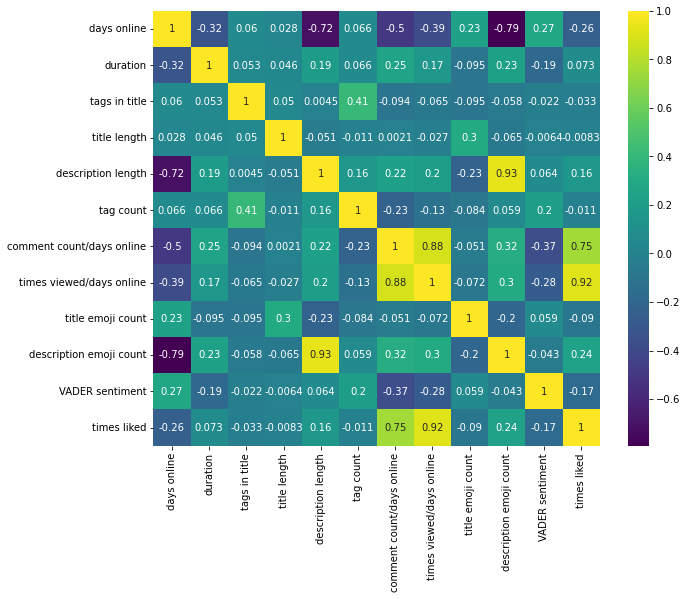

In [20]:
# Creating a correlation matrix of key features and presenting as a heat map
hayden_df = hayden_df[['video ids', 'publish date', 'tags', 'title', 'description',
                      "days online", "duration", 'tags in title', 'title length', 'description length', 
                      'tag count', 'comment count/days online', 'times viewed/days online', 'title emoji count', 
                       'description emoji count', 'VADER sentiment', 'day uploaded', 'month uploaded',
                       'times liked']]

correlation_matrix = pd.DataFrame(hayden_df.corr())
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis')
hayden_df.head(5)

Below I have one-hot encoded the categorical variables so they can be interpretted by regression models

In [21]:
# one hot-encoding the day of the week 
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(len(days)):# Seven days of the week 
    hayden_df[days[i]] = (hayden_df['publish date'].dt.dayofweek==i).astype(float)


# one hot-encoding the month of the week 
encoded_months = pd.get_dummies(hayden_df['month uploaded'])
hayden_df_numerical = pd.concat([hayden_df, encoded_months], axis = 1, join='inner')
hayden_df_numerical.head()

video ids              publish date  \
0  PrmGZMvCmA0 2022-05-27 02:08:45+00:00   
1  5s2HHJp03jg 2022-05-20 08:00:17+00:00   
2  bPUq-gy5TvQ 2022-05-09 06:49:56+00:00   
3  UOlia6gVDSs 2022-04-29 23:45:17+00:00   
4  Bn3Q4qDuYHM 2022-04-02 07:35:11+00:00   

                                                tags  \
0  [Australian fashion week, aafw, vlog, Chloe Ha...   
1  [harry styles, Harrys house, harry styles rect...   
2  [POTS, pots syndrome, postural orthostatic tac...   
3  [autism, Netflix, heartbreak high, actor, actr...   
4  [Chloe Hayden, Autism, autism awareness, autis...   

                                               title  \
0                I WALKED AT AUSTRALIAN FASHION WEEK   
1                              HARRYS HOUSE REACTION   
2  I was diagnosed with a chronic illness... here...   
3                       AUTISTIC NETFLIX ACTRESS Q&A   
4                            A CELEBRATION OF AUTISM   

                                         description  days online  duration  \
0  I WALKED IN FASHION WEEK AAAAHHHHH\n\n________...           22    1850.0   
1  This was a religious experience\n\n___________...           29    1641.0   
2  Hi butterflies! \nI filmed this video about si...           40     659.0   
3  Ahhh! I'm back! \n\n__________________________...           49    1290.0   
4  Happy Autism Acceptance Month.\nIt is time for...           77     320.0   

   tags in title  title length  description length  ...  December  February  \
0              1            35                1129  ...         0         0   
1              2            21                1126  ...         0         0   
2              0            64                1278  ...         0         0   
3              2            28                1111  ...         0         0   
4              1            23                1184  ...         0         0   

   January  July  June  March May November  October  September  
0        0     0     0      0   1        0        0          0  
1        0     0     0      0   1        0        0          0  
2        0     0     0      0   1        0        0          0  
3        0     0     0      0   0        0        0          0  
4        0     0     0      0   0        0        0          0  

[5 rows x 38 columns]

### Data Selection
Below I have listed the variables that will be taken into the next phase of the pipeline

In [22]:
# Selecting variables to build models with
clean = hayden_df_numerical.loc[:, ['days online', 'duration', 'tags in title', 'title length',
                               'description length', 'tag count', 'comment count/days online',
                               'times viewed/days online', 'title emoji count',
                               'description emoji count', 'VADER sentiment',
                                'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                'Saturday', 'Sunday','December', 'June', 'October', 'January', 
                                'February', 'March', 'April', 'May', 'July', 'August', 'September',
                                'November', 'times liked']]
clean.head()

days online  duration  tags in title  title length  description length  \
0           22    1850.0              1            35                1129   
1           29    1641.0              2            21                1126   
2           40     659.0              0            64                1278   
3           49    1290.0              2            28                1111   
4           77     320.0              1            23                1184   

   tag count  comment count/days online  times viewed/days online  \
0          4                   2.818182                126.500000   
1          6                   1.103448                185.551724   
2          6                   2.325000                138.025000   
3          6                   2.000000                111.612245   
4          6                   0.000000                 88.337662   

   title emoji count  description emoji count  ...  January  February  March  \
0                  0                       36  ...        0         0      0   
1                  0                       37  ...        0         0      0   
2                  3                       44  ...        0         0      0   
3                  0                       36  ...        0         0      0   
4                  0                       38  ...        0         0      0   

   April  May  July  August  September  November  times liked  
0      0    1     0       0          0         0          385  
1      0    1     0       0          0         0          362  
2      0    1     0       0          0         0          666  
3      1    0     0       0          0         0          630  
4      1    0     0       0          0         0         1051  

[5 rows x 31 columns]

In [23]:
#clean.to_csv('aspie_world.csv', index = False)

#### Issue and solution
Hayden alone does not have the amount of data points I would have hoped for and the models were poorly built. To resolve this, I have found channels that are similar in content and scale. This will increase the amount of data available in a manner that should produce a better model. This does however create some issues when it comes to the sentiment analysis as writing styles will differ and the true mean of description sentiment may be misplaced. 

Layle's channel provided only 3 similar videos as she doesn't regularly use tags, making all other videos uncomparable. 
The Aspie World's channel required some trimming of uploads due to duration length, but provided an additional 649 instances.

In [24]:
# combining the predictors:
hayden = pd.read_csv('chloe_hayden.csv')
layle = pd.read_csv('paige_layle.csv')
aw = pd.read_csv('aspie_world.csv')

data = pd.concat([hayden, layle, aw], axis = 0)
print("shape: ", data.shape)
print("")
print('Data types: \n', data.dtypes)
print("")
print('Missing values: \n', data.isna().sum())

# Fixing missing months from Paige's 3 videos
data.fillna(0, inplace = True)
print("\nMissing values related to the missing month columns from the three relevant rows from Layle's data")
print('Missing values: \n',data.isna().sum())

shape:  (888, 31)

Data types: 
 days online                    int64
duration                     float64
tags in title                  int64
title length                   int64
description length             int64
tag count                      int64
comment count/days online    float64
times viewed/days online     float64
title emoji count              int64
description emoji count        int64
VADER sentiment              float64
Monday                       float64
Tuesday                      float64
Wednesday                    float64
Thursday                     float64
Friday                       float64
Saturday                     float64
Sunday                       float64
December                       int64
June                           int64
October                        int64
January                      float64
February                     float64
March                        float64
April                        float64
May                          float64
July 

### Exploratory Data Analysis
Below I create some visualizations to get a sense of what transformations may be appropriate

In [25]:
data['index'] = (range(0,len(data)))
data.set_index('index', inplace = True)
print(data.columns)
data.head()

Index(['days online', 'duration', 'tags in title', 'title length',
       'description length', 'tag count', 'comment count/days online',
       'times viewed/days online', 'title emoji count',
       'description emoji count', 'VADER sentiment', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'December',
       'June', 'October', 'January', 'February', 'March', 'April', 'May',
       'July', 'August', 'September', 'November', 'times liked'],
      dtype='object')


days online  duration  tags in title  title length  description length  \
index                                                                           
0               19      49.0              1            35                1129   
1               37     399.0              0            64                1278   
2               46      53.0              2            28                1111   
3               74     277.0              1            23                1184   
4               85      54.0              3            36                1444   

       tag count  comment count/days online  times viewed/days online  \
index                                                                   
0              4                   3.105263                142.052632   
1              6                   2.513514                147.891892   
2              6                   2.108696                118.086957   
3              6                   0.000000                 91.729730   
4              9                   1.270588                 99.964706   

       title emoji count  description emoji count  ...  January  February  \
index                                              ...                      
0                      0                       36  ...      0.0       0.0   
1                      3                       44  ...      0.0       0.0   
2                      0                       36  ...      0.0       0.0   
3                      0                       38  ...      0.0       0.0   
4                      0                       44  ...      0.0       0.0   

       March  April  May  July  August  September  November  times liked  
index                                                                     
0        0.0    0.0  1.0   0.0     0.0        0.0       0.0          374  
1        0.0    0.0  1.0   0.0     0.0        0.0       0.0          661  
2        0.0    1.0  0.0   0.0     0.0        0.0       0.0          629  
3        0.0    1.0  0.0   0.0     0.0        0.0       0.0         1051  
4        1.0    0.0  0.0   0.0     0.0        0.0       0.0          823  

[5 rows x 31 columns]

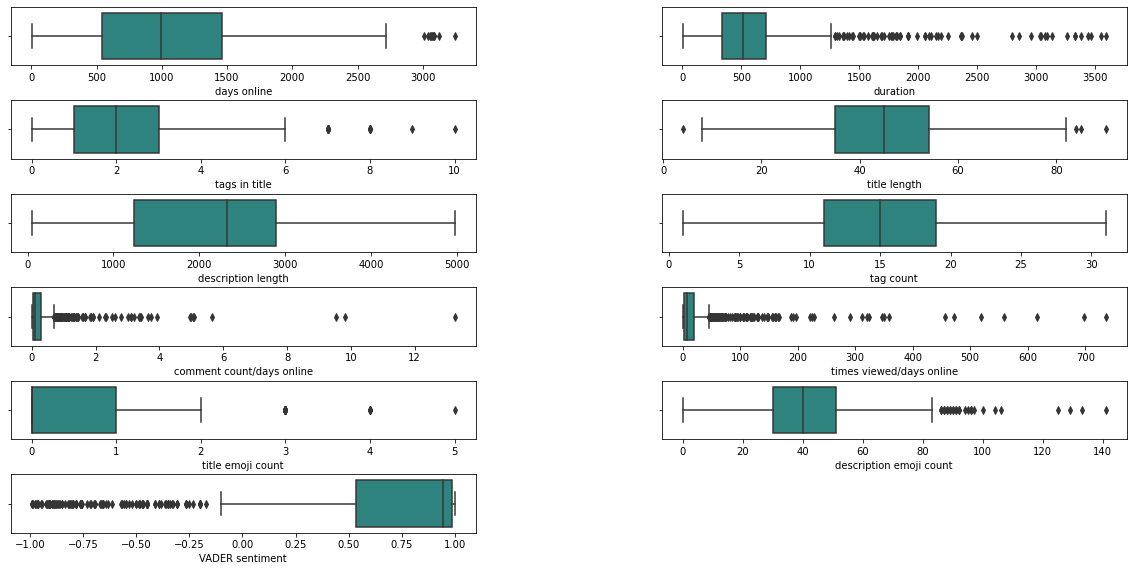

In [26]:
# Boxplot check
fig = plt.figure(figsize = (20,20))
fig.subplots_adjust(hspace = 0.6, wspace=0.4) # 40% of height/ width padding
for i in range(0, 11):
    plt.subplot(12, 2, i+1)
    sns.boxplot(x = data.iloc[:, i], data = data, palette = "viridis")

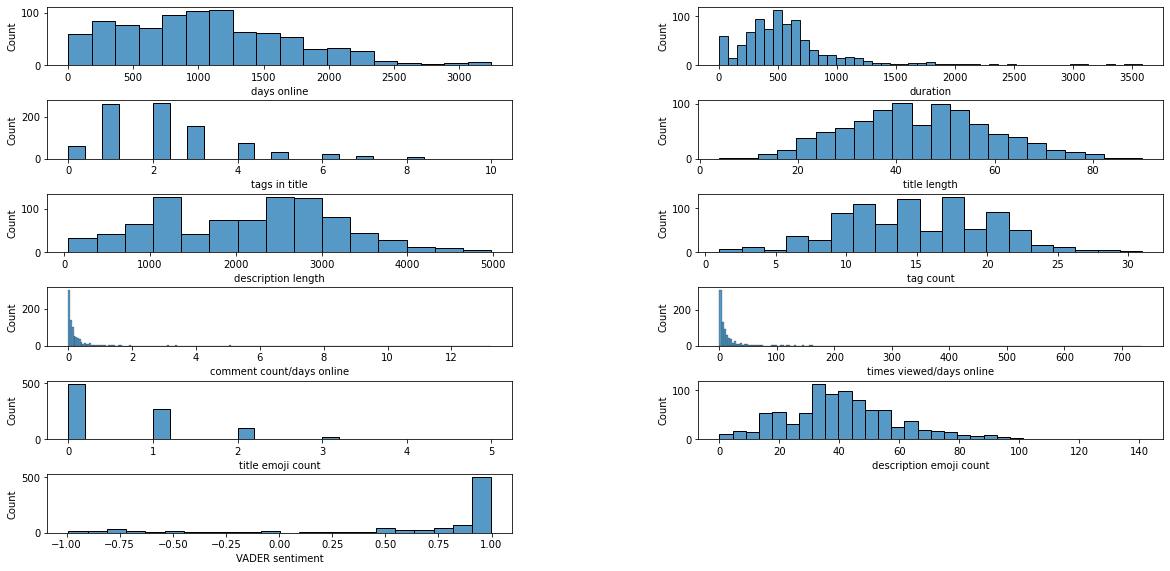

In [27]:
# Boxplot check
fig2 = plt.figure(figsize = (20,20))
fig2.subplots_adjust(hspace = 0.6, wspace=0.4) # 40% of height/ width padding
for i in range(0,11):
    plt.subplot(12, 2, i+1)
    sns.histplot(x = data.iloc[:,i], data = data, palette = "viridis")

From the above it is clear that some transofrmations may be beneficial, such as a transformation of log10(x+1) to account for the right skew in 'days online', 'duration', tags in title', 'comment count/days online', and 'times viewed/days online'. VADER sentiment was provided as a scaled value alreadu so we can't meaningfully alter its shape now.

In [28]:
# Transforming data
    # Adding one to prevent infinity
data['days online'] = np.log1p(data['days online'])
data['duration'] = np.log1p(data['duration'])
data['tags in title'] = np.log1p(data['tags in title'])
data['comment count/days online'] = np.log1p(data['comment count/days online'])
data['times viewed/days online'] = np.log1p(data['times viewed/days online'])

In [29]:
data.head()

days online  duration  tags in title  title length  description length  \
index                                                                           
0         2.995732  3.912023       0.693147            35                1129   
1         3.637586  5.991465       0.000000            64                1278   
2         3.850148  3.988984       1.098612            28                1111   
3         4.317488  5.627621       0.693147            23                1184   
4         4.454347  4.007333       1.386294            36                1444   

       tag count  comment count/days online  times viewed/days online  \
index                                                                   
0              4                   1.412270                  4.963213   
1              6                   1.256617                  5.003220   
2              6                   1.134203                  4.779854   
3              6                   0.000000                  4.529689   
4              9                   0.820039                  4.614771   

       title emoji count  description emoji count  ...  January  February  \
index                                              ...                      
0                      0                       36  ...      0.0       0.0   
1                      3                       44  ...      0.0       0.0   
2                      0                       36  ...      0.0       0.0   
3                      0                       38  ...      0.0       0.0   
4                      0                       44  ...      0.0       0.0   

       March  April  May  July  August  September  November  times liked  
index                                                                     
0        0.0    0.0  1.0   0.0     0.0        0.0       0.0          374  
1        0.0    0.0  1.0   0.0     0.0        0.0       0.0          661  
2        0.0    1.0  0.0   0.0     0.0        0.0       0.0          629  
3        0.0    1.0  0.0   0.0     0.0        0.0       0.0         1051  
4        1.0    0.0  0.0   0.0     0.0        0.0       0.0          823  

[5 rows x 31 columns]

Below I ensure all the relevant features are presented as z-scores (normalization). This also enables me to easily remove outliers sitting above three standard deviations away from the mean. I have decided to keep data with a z-score of negative three or lower because there would be too few instances to make accurate models with. 

In [30]:
# Creating Z-scores (Normalization to make ranges comparable) 
    # From 'days online' to 'description emoji count',
    # VADER sentiment has already been scaled
    # categorical data is fine as is
    
data.loc[:, 0:10] = data.iloc[:, 0:10].apply(lambda value: (value-value.mean())/ value.std(), axis=0)
data.head(3) 

C:\Users\rohad\AppData\Local\Temp\ipykernel_17000\4176641322.py:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[:, 0:10] = data.iloc[:, 0:10].apply(lambda value: (value-value.mean())/ value.std(), axis=0)


days online  duration  tags in title  title length  description length  \
index                                                                           
0        -3.869289 -2.285583      -0.791002     -0.679327           -1.007679   
1        -3.192583 -0.129417      -2.264874      1.323882           -0.861950   
2        -2.968480 -2.205783       0.071157     -1.162860           -1.025284   

       tag count  comment count/days online  times viewed/days online  \
index                                                                   
0      -2.121819                   3.821831                  2.106084   
1      -1.736507                   3.326217                  2.137274   
2      -1.736507                   2.936442                  1.963140   

       title emoji count  description emoji count  ...  January  February  \
index                                              ...                      
0              -0.751250                -0.272553  ...      0.0       0.0   
1               2.880927                 0.137141  ...      0.0       0.0   
2              -0.751250                -0.272553  ...      0.0       0.0   

       March  April  May  July  August  September  November  times liked  
index                                                                     
0        0.0    0.0  1.0   0.0     0.0        0.0       0.0          374  
1        0.0    0.0  1.0   0.0     0.0        0.0       0.0          661  
2        0.0    1.0  0.0   0.0     0.0        0.0       0.0          629  

[3 rows x 31 columns]

In [31]:
# Removing outliers 
    # Hayden's data continues to be a growing dataset, but there is not a sufficient amount of data to 
    # remove outlier instances in predictors yet, now that I have enough data compiled between the three I can be 
    # more selective
    
    # Getting data with maximums within 3 standard deviations of the mean 
data.iloc[:, 0:10] = data[(np.abs(stats.zscore(data.iloc[:, 0:10])) < 3)]
    # Same for target variable 
data.iloc[:, 31:] = data[(np.abs(stats.zscore(data.iloc[:, 31:])) < 3)]

# Assessing Values
data.head(100) # Compare times liked

days online  duration  tags in title  title length  description length  \
index                                                                           
0              NaN -2.285583      -0.791002     -0.679327           -1.007679   
1              NaN -0.129417      -2.264874      1.323882           -0.861950   
2        -2.968480 -2.205783       0.071157     -1.162860           -1.025284   
3        -2.475763 -0.506685      -0.791002     -1.508241           -0.953886   
4        -2.331472 -2.186757       0.682869     -0.610251           -0.699595   
...            ...       ...            ...           ...                 ...   
95        0.380271  0.081012       0.682869     -1.024708           -1.154386   
96        0.384009 -2.924505       0.682869      0.425892           -0.924545   
97        0.386804  0.050955       1.157350      0.564044           -1.025284   
98        0.390520  0.063943       0.682869     -0.333946           -1.038976   
99        0.394223 -0.190821       0.682869     -1.370089           -1.155364   

       tag count  comment count/days online  times viewed/days online  \
index                                                                   
0      -2.121819                        NaN                  2.106084   
1      -1.736507                        NaN                  2.137274   
2      -1.736507                   2.936442                  1.963140   
3      -1.736507                  -0.674966                  1.768116   
4      -1.158539                   1.936113                  1.834444   
...          ...                        ...                       ...   
95      0.575364                  -0.582910                 -0.543329   
96      2.116612                  -0.624602                 -1.221758   
97      2.116612                  -0.630277                 -1.098596   
98      1.538644                  -0.099580                  0.858469   
99      0.768020                   0.026593                  1.107143   

       title emoji count  description emoji count  ...  January  February  \
index                                              ...                      
0              -0.751250                -0.272553  ...      0.0       0.0   
1               2.880927                 0.137141  ...      0.0       0.0   
2              -0.751250                -0.272553  ...      0.0       0.0   
3              -0.751250                -0.170129  ...      0.0       0.0   
4              -0.751250                 0.137141  ...      0.0       0.0   
...                  ...                      ...  ...      ...       ...   
95             -0.751250                -0.733459  ...      0.0       0.0   
96              1.670201                -0.477400  ...      0.0       0.0   
97             -0.751250                -0.477400  ...      0.0       0.0   
98             -0.751250                -0.221341  ...      0.0       0.0   
99             -0.751250                -0.733459  ...      0.0       0.0   

       March  April  May  July  August  September  November  times liked  
index                                                                     
0        0.0    0.0  1.0   0.0     0.0        0.0       0.0          374  
1        0.0    0.0  1.0   0.0     0.0        0.0       0.0          661  
2        0.0    1.0  0.0   0.0     0.0        0.0       0.0          629  
3        0.0    1.0  0.0   0.0     0.0        0.0       0.0         1051  
4        1.0    0.0  0.0   0.0     0.0        0.0       0.0          823  
...      ...    ...  ...   ...     ...        ...       ...          ...  
95       0.0    0.0  1.0   0.0     0.0        0.0       0.0          254  
96       0.0    0.0  1.0   0.0     0.0        0.0       0.0           77  
97       0.0    0.0  1.0   0.0     0.0        0.0       0.0          103  
98       0.0    0.0  1.0   0.0     0.0        0.0       0.0         1792  
99       0.0    0.0  1.0   0.0     0.0        0.0       0.0         2075  

[100 rows x 31 columns]

In [32]:
# Removing outliers (instances with NaN values)
data.dropna(inplace = True)
data.shape
preprocessed = data.copy() 

Observing how these alterations have changed the shape of the data:

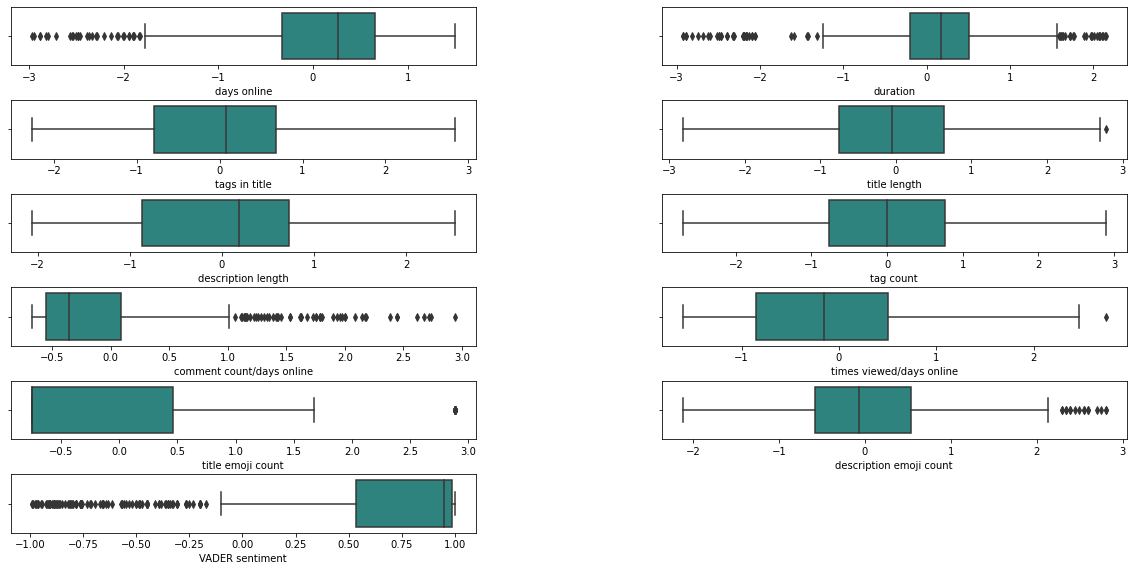

In [33]:
# Boxplot check
fig3 = plt.figure(figsize = (20,20))
fig3.subplots_adjust(hspace = 0.6, wspace=0.4) # 40% of height/ width padding
for i in range(0, 11):
    plt.subplot(12, 2, i+1)
    sns.boxplot(x = data.iloc[:, i], data = data, palette = "viridis")

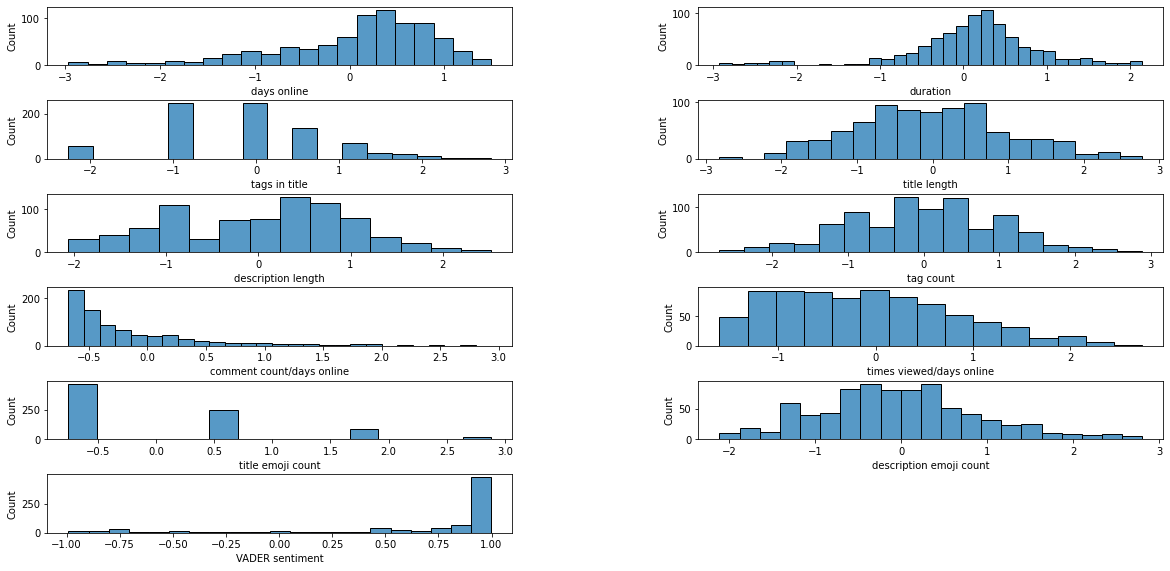

In [34]:
# Histogram check
fig2 = plt.figure(figsize = (20,20))
fig2.subplots_adjust(hspace = 0.6, wspace=0.4) # 40% of height/ width padding
for i in range(0,11):
    plt.subplot(12, 2, i+1)
    sns.histplot(x = data.iloc[:,i], data = data, palette = "viridis")

Observing how the Categorical data impacts like counts and using anove to measure significance:

In [35]:
# Categorical data - Bar chart for month 
    # Recreating 'month uploaded' column
data['id_vars'] = range(0,len(data))
months = pd.melt(data, id_vars = ['id_vars', 'times liked'], 
        value_vars = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                      'August', 'September', 'October', 'November', 'December'], 
        var_name = 'month uploaded', value_name = 'value')

valid_months = months.loc[months['value'] == 1.0]    

    # Creating a bar chart to demonstrate weekly upload habits
months_uploaded = px.bar(valid_months, x = "month uploaded",  
                         color = "times liked", 
                         title = "Videos uploaded per month coloured by the number of likes recieved")

    # Ordering x-axis chronologically
months_uploaded.update_xaxes(categoryorder='array', 
                             categoryarray= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                             'August', 'September', 'October', 'November', 'December'])

months_uploaded2 = px.bar(valid_months, x = "month uploaded",  
                         y = "times liked", 
                         title = "total likes recieved from videos uploaded in a given month")
months_uploaded2.update_xaxes(categoryorder='array', 
                             categoryarray= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                             'August', 'September', 'October', 'November', 'December'])

months_uploaded.show()
months_uploaded2.show()
valid_months.head()

id_vars  times liked month uploaded  value
25       25          680        January    1.0
47       47          765        January    1.0
48       48         1452        January    1.0
49       49           88        January    1.0
96       96          115        January    1.0

In [36]:
# Anova for 'month uploaded'
    # Data manipulatio
likes_by_month = pd.pivot(valid_months,index =['id_vars'], columns='month uploaded', values='times liked')
likes_by_month.replace(np. NaN, 0, inplace = True)


    # ANOVA
fvalue, pvalue = stats.f_oneway(likes_by_month['January'], likes_by_month['February'],
                                likes_by_month['March'], likes_by_month['April'],
                                likes_by_month['May'], likes_by_month['June'],
                                likes_by_month['July'], likes_by_month['August'],
                                likes_by_month['September'],likes_by_month['October'],
                                likes_by_month['November'], likes_by_month['December'])
print('ANOVA pvalue =', pvalue)
print('ANOVA fvalue =', fvalue)
likes_by_month.head()
# Not significant

ANOVA pvalue = 0.33367503233514895
ANOVA fvalue = 1.128315303865646


month uploaded   April  August  December  February  January  July  June  \
id_vars                                                                   
0                629.0     0.0       0.0       0.0      0.0   0.0   0.0   
1               1051.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                  0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                  0.0     0.0    2892.0       0.0      0.0   0.0   0.0   
4                  0.0     0.0       0.0       0.0      0.0   0.0   0.0   

month uploaded  March  May  November  October  September  
id_vars                                                   
0                 0.0  0.0       0.0      0.0        0.0  
1                 0.0  0.0       0.0      0.0        0.0  
2               823.0  0.0       0.0      0.0        0.0  
3                 0.0  0.0       0.0      0.0        0.0  
4                 0.0  0.0     539.0      0.0        0.0

In [37]:
# Categorical data - Bar chart for day
    # Recreating 'day uplaoded' column
days = pd.melt(data, id_vars = ['id_vars', 'times liked'], 
        value_vars = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
        var_name = 'day uploaded', value_name = 'value')
valid_days = days.loc[days['value'] == 1.0]
valid_days.head()


# Creating a bar chart to demonstrate weekly upload habits
day_uploaded = px.bar(valid_days, 
                      y = ['day uploaded'],  
                      color = "times liked", 
                      title = "Upload habits with instances coloured by total likes",
                      labels = {'count': 'Videos uploaded', "_value" : "Day of upload", "times liked" : "Times liked"})
day_uploaded.show()

In [38]:
# Anova for 'month uploaded'
    # finding likes for each upload by month
likes_by_day = pd.pivot(valid_days,index =['id_vars'], columns='day uploaded', values='times liked')
likes_by_day.replace(np. NaN, 0, inplace = True)
    # ANOVA
fvalue, pvalue = stats.f_oneway(likes_by_day['Monday'], likes_by_day['Tuesday'],
                                likes_by_day['Wednesday'], likes_by_day['Thursday'],
                                likes_by_day['Friday'], likes_by_day['Saturday'],
                                likes_by_day['Sunday'])
print('ANOVA pvalue =', pvalue)
print('ANOVA fvalue =', fvalue)
# Quite significant

likes_by_day.head()

ANOVA pvalue = 8.606568774053161e-27
ANOVA fvalue = 22.85604065303842


day uploaded  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
id_vars                                                                     
0              629.0     0.0       0.0     0.0       0.0      0.0        0.0
1                0.0     0.0    1051.0     0.0       0.0      0.0        0.0
2                0.0     0.0       0.0     0.0       0.0    823.0        0.0
3                0.0  2892.0       0.0     0.0       0.0      0.0        0.0
4                0.0     0.0       0.0   539.0       0.0      0.0        0.0

Performing a PCA to determine how much variance is in the data and how many components are required to adequately explain it:


Explained Variance:

[2.32946191e-01 1.49176495e-01 1.08764124e-01 9.64606768e-02
 6.76400646e-02 5.44634346e-02 5.38578762e-02 3.56991752e-02
 2.74056043e-02 2.34333015e-02 1.54526883e-02 1.18727260e-02
 1.11851522e-02 9.67564167e-03 9.21090439e-03 8.95783110e-03
 8.84018901e-03 8.78607683e-03 8.48811273e-03 7.81294569e-03
 7.68752764e-03 7.54444882e-03 6.63680707e-03 6.54093981e-03
 6.23831164e-03 6.00500591e-03 5.48995644e-03 3.72779099e-03
 4.59405358e-32 2.65568937e-33]

The number of components needed to explain 95% of the variance is 20


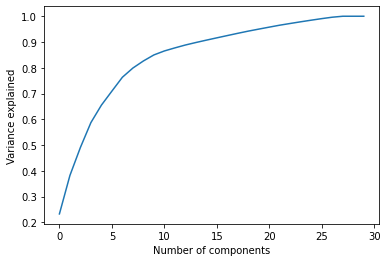

In [39]:
# Performing PCA on predictor variables
from sklearn.decomposition import PCA
data_pca = data.iloc[:, 0:30] 
pca = PCA(n_components = 30 ) # Just show first 4 components
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
fit = pca.fit(data_pca.select_dtypes(include=numerics))

print("\nExplained Variance:\n")
print(fit.explained_variance_ratio_)        

# Plotting explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

# Explaining 95% of the variance
pca = PCA(0.95)
pca.fit(data_pca)
reduced = pca.transform(data_pca)
print("\nThe number of components needed to explain 95% of the variance is", pca.n_components_)

Resetting the index since outlier instances were removed 

In [40]:
preprocessed.reset_index(inplace=True)
preprocessed.drop('index', axis=1, inplace=True)
preprocessed.head()

days online  duration  tags in title  title length  description length  \
0    -2.968480 -2.205783       0.071157     -1.162860           -1.025284   
1    -2.475763 -0.506685      -0.791002     -1.508241           -0.953886   
2    -2.331472 -2.186757       0.682869     -0.610251           -0.699595   
3    -1.523870 -0.940248      -0.791002     -0.886556           -1.019415   
4    -1.370342 -2.491357      -0.791002     -1.922698           -1.046801   

   tag count  comment count/days online  times viewed/days online  \
0  -1.736507                   2.936442                  1.963140   
1  -1.736507                  -0.674966                  1.768116   
2  -1.158539                   1.936113                  1.834444   
3  -1.351195                   2.443755                  2.462662   
4  -1.158539                   0.184483                  0.941756   

   title emoji count  description emoji count  ...  January  February  March  \
0           -0.75125                -0.272553  ...      0.0       0.0    0.0   
1           -0.75125                -0.170129  ...      0.0       0.0    0.0   
2           -0.75125                 0.137141  ...      0.0       0.0    1.0   
3           -0.75125                -0.272553  ...      0.0       0.0    0.0   
4           -0.75125                -0.272553  ...      0.0       0.0    0.0   

   April  May  July  August  September  November  times liked  
0    1.0  0.0   0.0     0.0        0.0       0.0          629  
1    1.0  0.0   0.0     0.0        0.0       0.0         1051  
2    0.0  0.0   0.0     0.0        0.0       0.0          823  
3    0.0  0.0   0.0     0.0        0.0       0.0         2892  
4    0.0  0.0   0.0     0.0        0.0       1.0          539  

[5 rows x 31 columns]

Checking the correlation once more now that values have been transformed and normalised

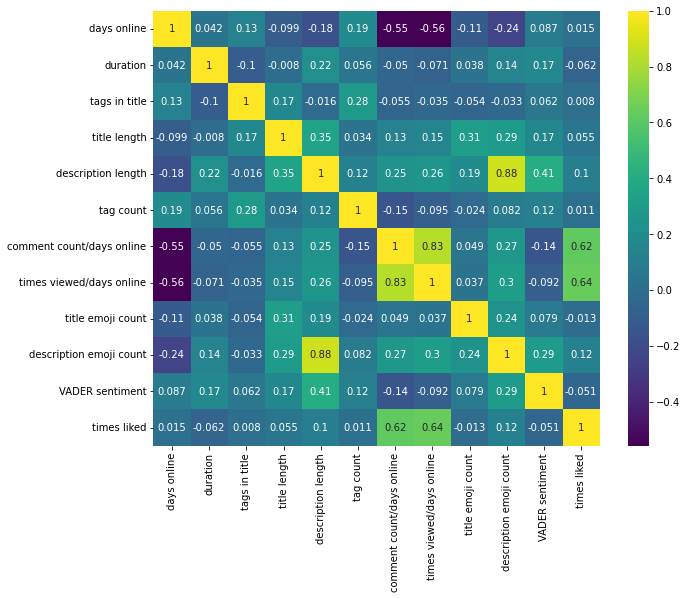

In [41]:
corr_matrix = pd.DataFrame(preprocessed.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,-1]].corr())
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot = True, cmap = 'viridis')


Observing the target variable now to determine if it could benefit from any modification

<AxesSubplot:xlabel='times liked', ylabel='Count'>

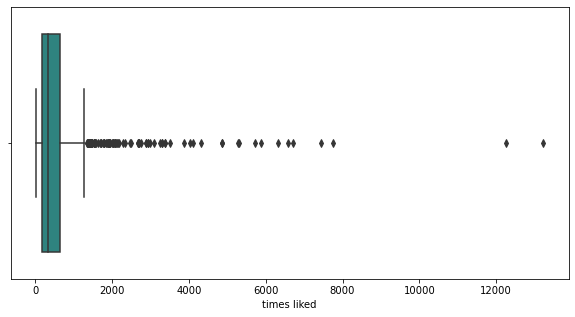

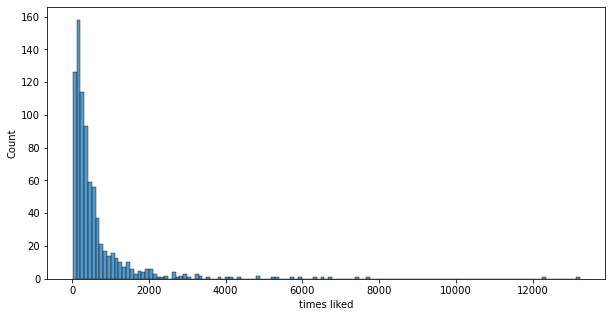

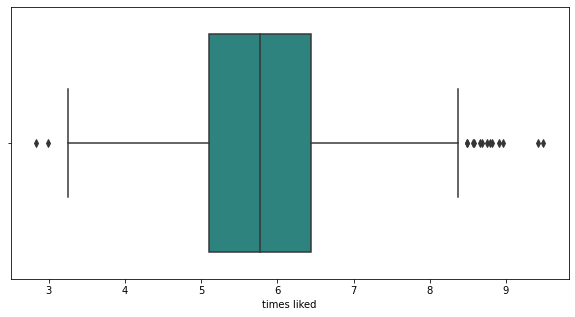

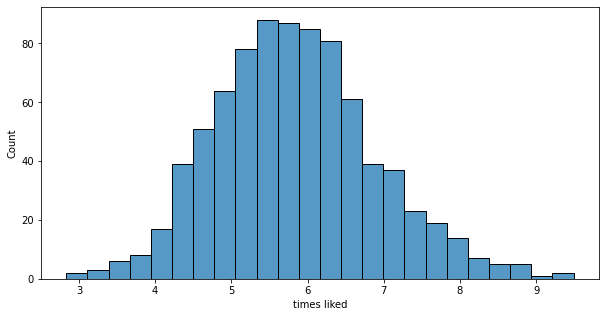

In [42]:
# Viewing spread in relation to times liked
    # Boxplot check
times_liked_box = plt.figure(figsize = (10,5))
sns.boxplot(x = 'times liked', data = preprocessed, palette = "viridis")

    # Histogram check
times_liked_hist = plt.figure(figsize = (10,5))
sns.histplot(x = "times liked", data = preprocessed, palette = "viridis")

# After transformation
times_liked_box_transformed = plt.figure(figsize = (10,5))
sns.boxplot(x = np.log1p(preprocessed['times liked']), data = preprocessed, palette = "viridis")

    # Histogram check
times_liked_hist_transformed = plt.figure(figsize = (10,5))
sns.histplot(x = np.log1p(preprocessed['times liked']), data = preprocessed, palette = "viridis")


Transforming target variable by log10(x+1) and checking heat map once more. Seems to have improved.

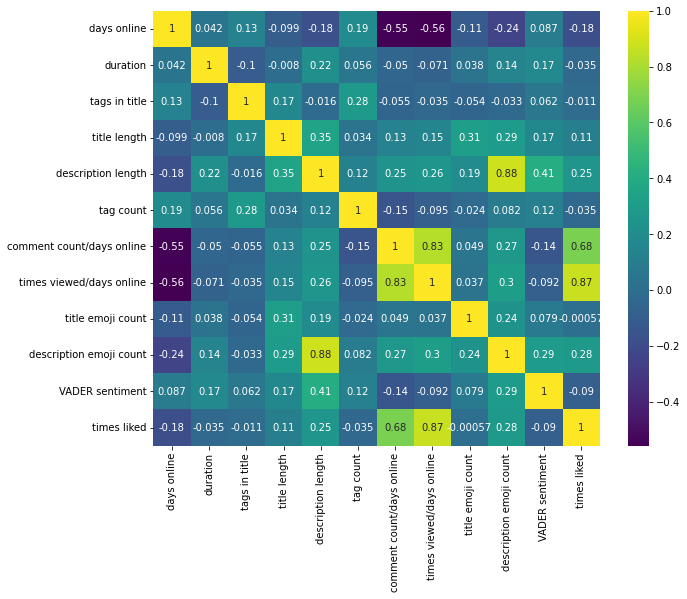

In [43]:
# Comparing relation after transformation of target variable
preprocessed['times liked'] = np.log1p(preprocessed['times liked'])

corr_matrix = pd.DataFrame(preprocessed.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,-1]].corr())
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot = True, cmap = 'viridis')


In [44]:
X = preprocessed.iloc[:, 0:30]
#X.to_csv("X.csv", index = False)
X.head()

days online  duration  tags in title  title length  description length  \
0    -2.968480 -2.205783       0.071157     -1.162860           -1.025284   
1    -2.475763 -0.506685      -0.791002     -1.508241           -0.953886   
2    -2.331472 -2.186757       0.682869     -0.610251           -0.699595   
3    -1.523870 -0.940248      -0.791002     -0.886556           -1.019415   
4    -1.370342 -2.491357      -0.791002     -1.922698           -1.046801   

   tag count  comment count/days online  times viewed/days online  \
0  -1.736507                   2.936442                  1.963140   
1  -1.736507                  -0.674966                  1.768116   
2  -1.158539                   1.936113                  1.834444   
3  -1.351195                   2.443755                  2.462662   
4  -1.158539                   0.184483                  0.941756   

   title emoji count  description emoji count  ...  October  January  \
0           -0.75125                -0.272553  ...        0      0.0   
1           -0.75125                -0.170129  ...        0      0.0   
2           -0.75125                 0.137141  ...        0      0.0   
3           -0.75125                -0.272553  ...        0      0.0   
4           -0.75125                -0.272553  ...        0      0.0   

   February  March  April  May  July  August  September  November  
0       0.0    0.0    1.0  0.0   0.0     0.0        0.0       0.0  
1       0.0    0.0    1.0  0.0   0.0     0.0        0.0       0.0  
2       0.0    1.0    0.0  0.0   0.0     0.0        0.0       0.0  
3       0.0    0.0    0.0  0.0   0.0     0.0        0.0       0.0  
4       0.0    0.0    0.0  0.0   0.0     0.0        0.0       1.0  

[5 rows x 30 columns]

In [45]:
y = preprocessed.iloc[:, 30:31]
#y.to_csv("y.csv", index = False)
y.head()

times liked
0     6.445720
1     6.958448
2     6.714171
3     7.970049
4     6.291569

## Feature selection Summary
The features below have been selected because they either correlate well or are expected to have interactive terms or latent information that could be useful in more complex models:

Numerical features:
1. Days since upload - the longer a video is online, the more opportunities it has to get liked.
1. Video duration - the length of a video may put people off watching or conversely provide viewers a longer window of oppurtunity to like the video.
1. No. tags in title - an indicator of how relevant the video is to a search term and may lead to more likes.
1. Title length - Longer titles or titles that are too short may not get as many viewers. Less viewers results in less oppurtunities to recieve a like.
1. Description length - The length of a description is an indicator of how content heavy the video is. Viewers looking for information may like these videos. Potential interaction term with number of tags.
1. No. of tags - more tags results in better SEO and traffic. Relevance to viewers may result in more likes.
1. Average comment count per day - if viewers have taken the time to comment, they may have taken the time to like the video.
1. Average views per day - the more views a video gets, the more opportunities there are for likes.
1. No. of emojis in title - emojis illicit an emotional response and connection. The view has a simple way to interact back with the like button, so emojis may result in more likes as a result of simple human nature. 
1. No. of emojis in description - as above.
1. Description sentiment - an indicator of emotion, may lead to an emotional response in the form of a like.

One Hot Encoded Categorical features:

1. Weekday of uploaded - as YouTube algorythms bury old videos, it is expected that videos uploaded on days people typically have spare time (Friday, Saturday, Sunday) will typically be viewed more and recieve more liked.
1. Month of uploaded - some months have more school holidays, public holidays, etc. More free time results in more viewers and a high probability of more likes.
